In [212]:
import importlib
import data_preprocessor
import helper_functions
import cluster_validation as cv
import cluster_plotting as cp
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importlib.reload(data_preprocessor)
importlib.reload(helper_functions)
importlib.reload(cv)
importlib.reload(cp)

from helper_functions import load_dataset, save_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from data_preprocessor import DataPreprocessor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, BisectingKMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [213]:
data = load_dataset("../data/assignment3_articles.xlsx")

## 1) Data Inspection and Preparation

First, we do some basic inspection of the dataset, such as checking the first few rows, the data types, the amount of missing values, and the value counts of certain columns.

In [214]:
data

,index,headlines,description,content
0,0,Rupee ends 1 paisa lower at 83.38 against US d...,"Besides, selling pressure in the domestic equi...",The rupee consolidated in a narrow range and s...
1,1,"India vs Syria Live Streaming, AFC Asian Cup 2...","AFC Asian Cup Live Streaming, India vs Syria F...",India vs Syria AFC Asia Cup Live Streaming Det...
2,2,"PM Modi to interact with VCs, teachers, studen...",G20 University Connect: The commission has ask...,The University Grants Commission (UGC) is orga...
3,3,"How to remove bloatware apps from Samsung, Rea...",Smartphone companies often ship Android phones...,Smartphone manufacturers often pack new Androi...
4,4,NEET SS 2023 result declared; counselling sche...,NEET SS 2023 Result: Candidates who appeared f...,The National Board of Examinations Medical Sci...
...,...,...,...,...
2495,2495,Google Search and Lens can now visualise STEM ...,Google Search and Lens can now help students w...,Google has been consistently improving its Sea...
2496,2496,Arsenal’s Partey an injury doubt as Arteta rel...,Partey came off at halftime during Arsenal's F...,Arsenal midfielder Thomas Partey is still an i...
2497,2497,"iQOO 12 will get 3 Android updates, will not h...","iQOO says its upcoming flagship phone, running...",iQOO is all set to launch its upcoming flagshi...
2498,2498,Lava Blaze Pro 5G review: Is this the best 5G ...,Lava Blaze Pro 5G is an excellent 5G smartphon...,"In less than a year, India has accounted for o..."


In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2500 non-null   int64 
 1   headlines    2500 non-null   object
 2   description  2500 non-null   object
 3   content      2500 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


### Preprocessing the text data

In [216]:
# Initialize the DataPreprocessor object
preprocessor = DataPreprocessor()

We quickly how below how the preprocessor works by applying it to the first row of the content column.

In [217]:
# get first row and last column
data.iloc[0, -1]

'The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCur

In [218]:
preprocessor.preprocess_text(data.iloc[0, -1])

'rupe consolid narrow rang settl paisa lower provision us dollar tuesday investor prefer remain cautiou ahead domest inflat data releas upcom us fed meet besid sell pressur domest equiti market dent market sentiment forex trader said howev weaker american currenc major currenc oversea restrict loss local currenc ad interbank foreign exchang market local unit open settl provision greenback regist loss paisa previou close intraday rupe touch high hit lowest level monday domest currenc settl us dollar investor larg remain concern domest inflat data well industri product number announc later day currenc trader also await us feder reserv monetari polici decis like announc later week upcom focu us cpi data even expect per cent monthonmonth basi lower yearonyear figur per cent anticip mix reaction rupe seem unaffect persist within broad rang jateen trivedi vp research analyst lkp secur said meanwhil dollar index gaug greenback strength basket six currenc trade per cent lower tuesday brent cru

### Data Preprocessing

In [219]:
def count_numbers(text):
    """
    Count the occurrences of numbers in the text.
    """
    # match numbers
    pattern = r'\b\d+[,.]\d+\b|\b\d+[,.]?\b|\b[,.]\d+\b'
    return len(re.findall(pattern, text))

def preprocess_col(preprocessor: DataPreprocessor, col: pd.Series, h_pct: float = 0, l_pct: float = 0) -> pd.Series:
    """ 
    Preprocesses a column of text data using the preprocessor (cfr. data_preprocessor.py), 
    and by removing the top $h_pct of the most frequent words and the top $l_pct of the least frequent words.
    
    Inspired partly by: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e
    
    :param preprocessor: preprocessor object
    :param col: column of text data
    :param h_pct: "the percentage of high frequency words to remove from the corpus"
    :param l_pct: "the percentage of low frequency words to remove from the corpus"
    :return: preprocessed column
    """

    col = col.apply(preprocessor.preprocess_text)
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(col).split()).value_counts()[:int(pd.Series(' '.join(col).split()).count()*h_pct/100)]
        rem_high = col.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = col
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

We concatenate the headlines, descriptions, and preprocessed content columns into a single column, and preprocess the concatenated column.

In [220]:
# count amount of numbers in content column
data['amount_of_numbers'] = data['content'].apply(count_numbers)

data['preprocessed_content'] = preprocess_col(preprocessor, data['content'], h_pct=1, l_pct=1)
data['concatenated'] = data['headlines'] + ' ' + data['description'] + ' ' + data['preprocessed_content']
data['preprocessed_concat'] = preprocess_col(preprocessor, data['concatenated'], h_pct=0, l_pct=0)

data_preprocessed = data.drop(columns=['headlines', 'description', 'content', 'preprocessed_content', 'concatenated'])

In [221]:
data_preprocessed

,index,amount_of_numbers,preprocessed_concat
0,0,27,rupe end paisa lower us dollar besid sell pres...
1,1,5,india vs syria live stream afc asian cup watch...
2,2,4,pm modi interact vc teacher student ugc univer...
3,3,0,remov bloatwar app samsung realm xiaomi vivo r...
4,4,2,neet ss result declar counsel schedul soon nat...
...,...,...,...
2495,2495,0,googl search len visualis stem model help calc...
2496,2496,1,arsen partey injuri doubt arteta reli jorginho...
2497,2497,10,iqoo get android updat hot app hot game iqoo s...
2498,2498,1,lava blaze pro review best phone rs lava blaze...


We vectorize the preprocessed text data using the TF-IDF method.

In [222]:
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(data_preprocessed['preprocessed_concat']) # Vectorize preprocessed text data
vectorized_data_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_features = vectorized_data_df.copy()

In [223]:
tfidf_features

,aa,aaa,aac,aacha,aacsb,aadat,aadhaar,aadhaarvalid,aadhya,aadmi,...,zonewhuev,zoolog,zoom,zorzi,zouma,zoya,zozo,zuckerberg,zulfon,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model
n_topics = 5  # Number of topics to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(vectorized_data)

# Get the topic distribution for each document
topic_distribution = lda.transform(vectorized_data)
d = data.copy()
d['topic'] = np.argmax(topic_distribution, axis=1)

In [225]:
d['topic'].value_counts()

topic
2    619
4    602
3    428
1    426
0    425
Name: count, dtype: int64

In [226]:
# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 20
print("Topics in LDA model:")
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

# Count the number of articles for each topic
topic_counts = d['topic'].value_counts()
print("Number of articles per topic:")
print(topic_counts)

Topics in LDA model:
Topic #0:
exam khan india univers ug class first indian new australia cbse boman ctet world said student say cuet board neet
Topic #1:
result cuet check exam jee student offici websit khan ug india declar main iit year say test releas june nta
Topic #2:
rs cent per crore collect film india offic day box year inflat sensex rbi said khan bank anim point report
Topic #3:
india student say year rs kapoor ai open univers khan indian new neet gold cricket watch women said world first
Topic #4:
googl ai new india galaxi featur neet counsel samsung appl launch news today watch tech ug user app share pro

Number of articles per topic:
topic
2    619
4    602
3    428
1    426
0    425
Name: count, dtype: int64


### Clustering

### KMeans

In [227]:
random_state = 1

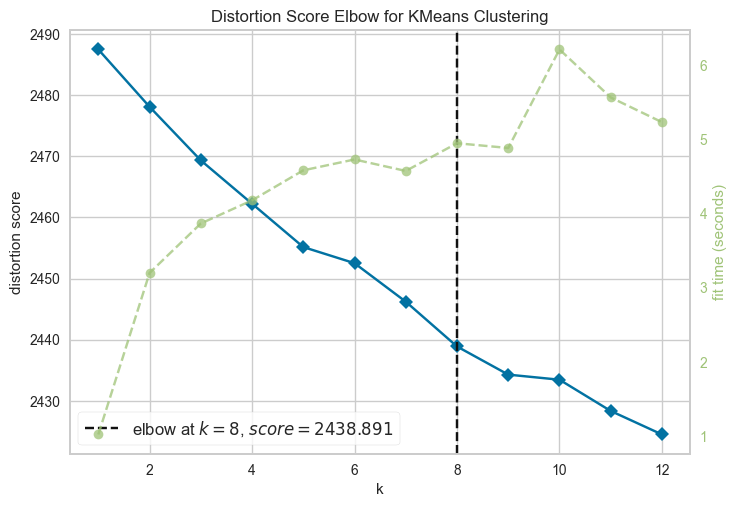

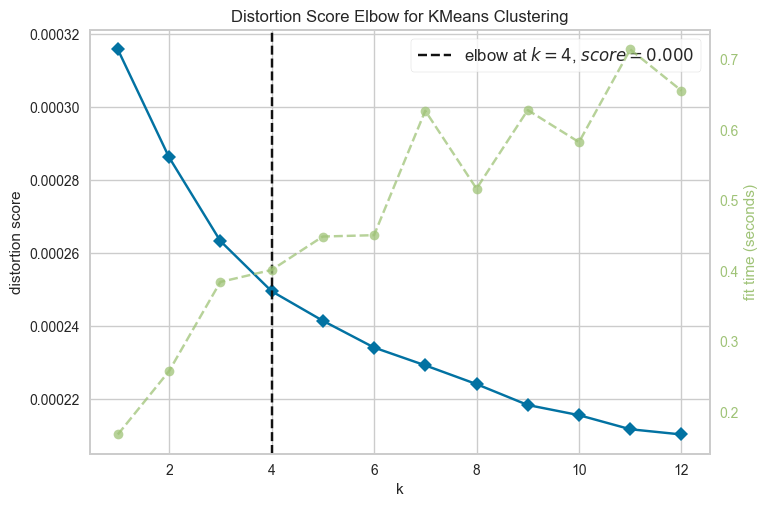

In [228]:
cp.elbow_method_plot(KMeans(random_state=random_state, n_init=10), tfidf_features, max_k=12)
cp.elbow_method_plot(KMeans(random_state=random_state, n_init=10), cosine_distances(tfidf_features), max_k=12, distance_metric='cosine')

In [152]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df = cosine_distances(tfidf_features).copy()
kmeans.fit(df)
cluster_labels = kmeans.labels_

# Evaluate clustering using silhouette score (optional)
silhouette_avg = silhouette_score(df, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmeans.inertia_)

# Assign cluster labels to documents in the dataset
labels = tfidf_features.copy()
labels['cluster'] = cluster_labels

Silhouette Score: 0.06359772209443748
Inertia: 3743.6897966472225


In [153]:
cv.cv_statistics(kmeans, cluster_labels, df, num_clusters, metric='cosine', n_permutations=10, verbose=True)

Permutation 1/10
Permutation 2/10
Permutation 3/10
Permutation 4/10
Permutation 5/10
Permutation 6/10
Permutation 7/10
Permutation 8/10
Permutation 9/10
Permutation 10/10
---
Actual SSE: 3743.690
Random SSE: Mean: 4078.466, Std: 1.435
SSE Z-Score: -233.295
=> SSE is Atypical: True
---
Actual Silhouette Score: 0.064
Random Silhouette: Mean: 0.013, Std: 0.028
Silhouette Z-Score: 1.838
=> Silhouette Score is Atypical: False
---
Actual Correlation: -0.611
Random Correlation: Mean: -0.105, Std: 0.046
Correlation Z-Score: -11.102
=> Correlation is Atypical: True


(-233.29455658547758,
 1.837938833674864,
 -11.101602457778025,
 True,
 False,
 True)

In [154]:
labels['cluster'].value_counts()

cluster
2    1923
0     218
3     168
4     150
1      41
Name: count, dtype: int64

In [155]:
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

# print top words for each cluster
for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: aiyaaa, ambul, barrel, amfi, bachelor, bnp, arsenio, ar, backcourt, biodivers
Cluster 2: bodylin, beyonc, anticip, big, bacho, allegi, behrendorff, bpe, adroit, behold
Cluster 3: agre, ag, admiss, aparna, ali, battlefield, assent, aagi, aishwarya, ageless
Cluster 4: apparatu, ajl, adfre, airborn, afridi, bopannabhambri, abdul, bendebka, bound, arnold
Cluster 5: bachelor, barrel, afi, attrit, betray, aishwarya, admonish, bamstarr, brick, beetl


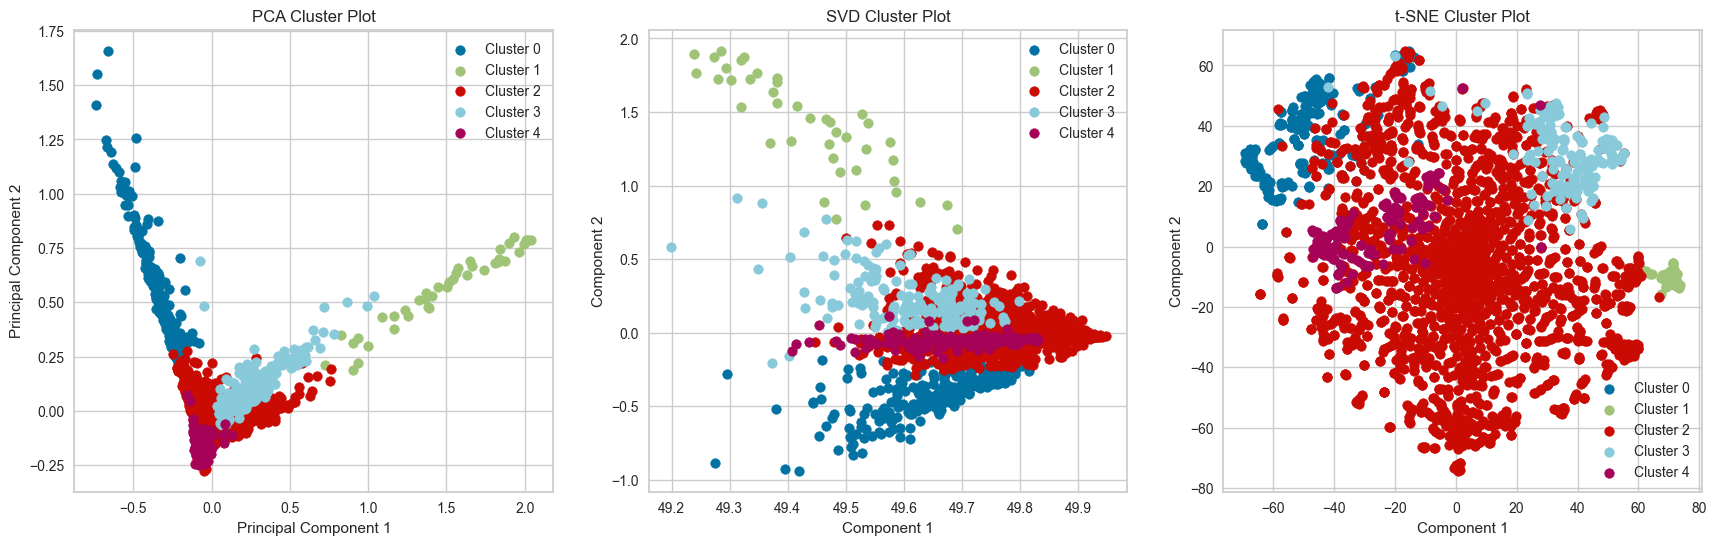

In [156]:
cp.plot_clusters_2d_all(df, cluster_labels)

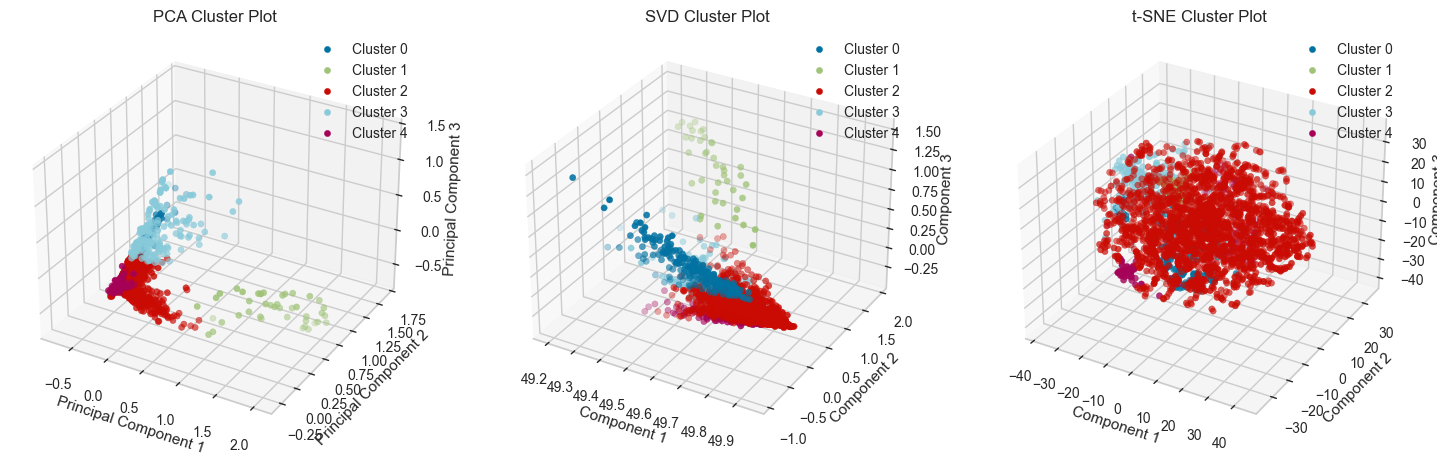

In [157]:
cp.plot_clusters_3d_all(df, cluster_labels)

In [158]:
centroids = kmeans.cluster_centers_
feature_names = tfidf.get_feature_names_out()
num_clusters = 5

# print top words for each cluster
for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: aiyaaa, ambul, barrel, amfi, bachelor, bnp, arsenio, ar, backcourt, biodivers
Cluster 2: bodylin, beyonc, anticip, big, bacho, allegi, behrendorff, bpe, adroit, behold
Cluster 3: agre, ag, admiss, aparna, ali, battlefield, assent, aagi, aishwarya, ageless
Cluster 4: apparatu, ajl, adfre, airborn, afridi, bopannabhambri, abdul, bendebka, bound, arnold
Cluster 5: bachelor, barrel, afi, attrit, betray, aishwarya, admonish, bamstarr, brick, beetl


### Bisecting KMeans

In [159]:
tfidf_features = vectorized_data_df
num_clusters = 7
bkmeans = BisectingKMeans(n_clusters=num_clusters, random_state=42)
bkmeans.fit(tfidf_features)
cluster_labels = bkmeans.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", bkmeans.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.0036343706278808086
Inertia: 2457.262642599124


### KMedoids

In [160]:
tfidf_features = vectorized_data_df
num_clusters = 7
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42)
kmedoids.fit(tfidf_features)
cluster_labels = kmedoids.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmedoids.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.10670538843165459
Inertia: 3747.4066084389524


In [161]:
tfidf_features = vectorized_data_df
num_clusters = 7
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine')
kmedoids.fit(tfidf_features)
cluster_labels = kmedoids.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmedoids.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: -0.08718158318050755
Inertia: 173.82763161119945


### DBSCAN

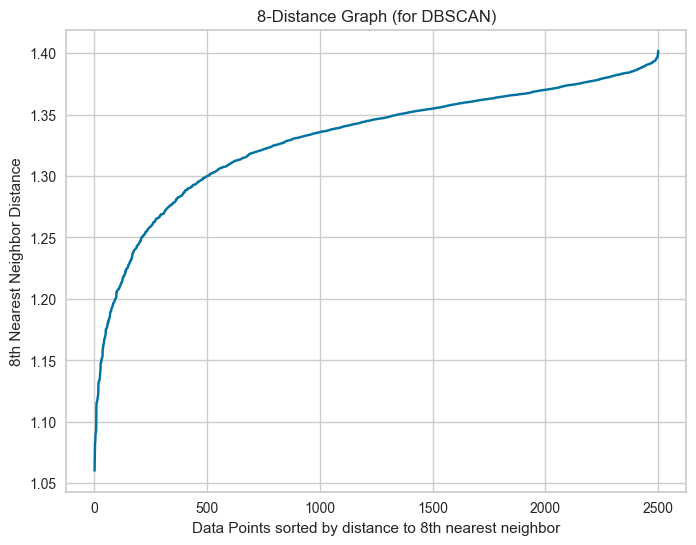

In [162]:
cp.plot_k_distance_graph(text, k=8)

In [163]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.55, min_samples=8, metric='cosine')
clusters = dbscan.fit_predict(text)

In [164]:
# check amount of items per cluster
unique, counts = np.unique(clusters, return_counts=True)
# print amount of items per cluster
dict(zip(unique, counts))

{0: 2500}

### Expectation Maximization

In [165]:
# tfidf_features = vectorized_data_df
# num_clusters = 5
# em = GaussianMixture(n_components=num_clusters, random_state=42, max_iter=20)
# em.fit(tfidf_features)
# cluster_labels = em.predict(tfidf_features)
# 
# # Evaluate clustering using silhouette score
# silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
# print("Silhouette Score:", silhouette_avg)
# print("BIC:", em.bic(tfidf_features))

In [166]:
# Vectorize the text data
tfidf = TfidfVectorizer()
tfidf.fit(data.preprocessed_concat)
text = tfidf.transform(data.preprocessed_concat)

def plot_bic_aic(text_data, max_components=10):
    bic = []
    aic = []
    n_components_range = range(1, max_components + 1)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(text_data.toarray())
        bic.append(gmm.bic(text_data.toarray()))
        aic.append(gmm.aic(text_data.toarray()))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, bic, marker='o', label='BIC')
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC vs. Number of components')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, aic, marker='o', label='AIC')
    plt.xlabel('Number of components')
    plt.ylabel('AIC')
    plt.title('AIC vs. Number of components')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
# plot_bic_aic(text, max_components=10)

In [167]:
def cross_val_log_likelihood(text_data, max_components=10):
    n_components_range = range(1, max_components + 1)
    log_likelihoods = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        log_likelihood = 0
        
        for train_index, test_index in skf.split(text_data, np.zeros(text_data.shape[0])):
            gmm.fit(text_data[train_index].toarray())
            log_likelihood += gmm.score(text_data[test_index].toarray())
        
        log_likelihoods.append(log_likelihood / skf.n_splits)
    
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range, log_likelihoods, marker='o')
    plt.xlabel('Number of components')
    plt.ylabel('Log-Likelihood')
    plt.title('Log-Likelihood vs. Number of components')
    plt.grid(True)
    plt.show()

# Example usage
# cross_val_log_likelihood(text, max_components=10)

### Hierarchical Clustering

#### Agglomerative Clustering

In [168]:
tfidf_features = vectorized_data_df
num_clusters = 7
agg = AgglomerativeClustering(n_clusters=num_clusters, metric='cosine', linkage='average')
agg.fit(tfidf_features)
cluster_labels = agg.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.06488688320850462


In [169]:

# data = pd.DataFrame({'preprocessed_concat': ["This is the first document.", "This document is the second document.", 
#                                              "And this is the third one.", "Is this the first document?"]})
# Vectorize the text data
# tfidf = TfidfVectorizer()
# tfidf.fit(data.preprocessed_concat)
# text = tfidf.transform(data.preprocessed_concat)


# Perform K-Means Clustering
# kmeans = KMeans(n_clusters=7, random_state=42)
# clusters = kmeans.fit_predict(vectorized_data)
# 
# # Measure Cluster Validity
# correlation = correlation(vectorized_data, clusters, metric='cosine')
# print(f'Cluster Validity Correlation: {correlation:.3f}')

In [170]:
# print all entries per cluster
for i in range(7):
    print(f'Cluster {i}:')
    print(data_preprocessed[clusters == i])
    print()

Cluster 0:
      index  amount_of_numbers  \
0         0                 27   
1         1                  5   
2         2                  4   
3         3                  0   
4         4                  2   
...     ...                ...   
2495   2495                  0   
2496   2496                  1   
2497   2497                 10   
2498   2498                  1   
2499   2499                  1   

                                    preprocessed_concat  
0     rupe end paisa lower us dollar besid sell pres...  
1     india vs syria live stream afc asian cup watch...  
2     pm modi interact vc teacher student ugc univer...  
3     remov bloatwar app samsung realm xiaomi vivo r...  
4     neet ss result declar counsel schedul soon nat...  
...                                                 ...  
2495  googl search len visualis stem model help calc...  
2496  arsen partey injuri doubt arteta reli jorginho...  
2497  iqoo get android updat hot app hot game iqoo s...  


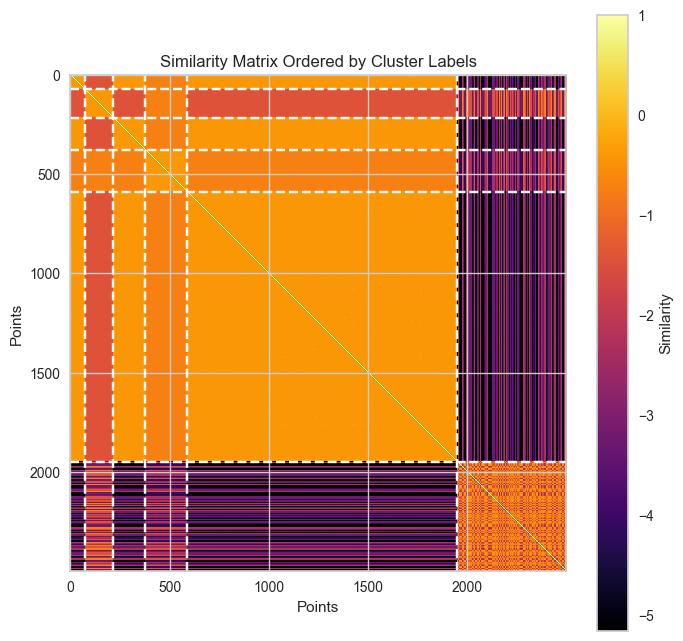

In [171]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(cosine_distances(vectorized_data_df))

cv.cv_similarity_matrix(vectorized_data_df, clusters, metric='euclidean')